<a href="https://colab.research.google.com/github/rahulakrish/portfolio_builder/blob/main/mpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yahoofinancials

In [2]:
#importing libraries

import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
import numpy as np
import pandas as pd
import itertools
from datetime import datetime
from datetime import date
from dateutil import relativedelta
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from scipy.signal._signaltools import _centered
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')
import logging
import cmdstanpy
# logging.basicConfig(level=logging.CRITICAL)
# mlogger = logging.getLogger('matplotlib')
# mlogger.setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel('WARNING')

# EDA

For demonstrative purposes, let's build a porfiolio of stock of the following companies: General Electric, J.P.Morgan, Microsoft and Prcter & Gamble.

Stock data for analysis and modeling will be collected from 2019-till date.

To make preliminary calculations of portfolio perfomance, let's assume an equally weighted portfolio i.e. 25% investement in 4 different assets.

In [3]:
# define date
start_date = '2019-01-01'
end_date = date.today()

#sample weights for portfolio returns calculations
weights = np.array([0.25,0.25,0.25,0.25])

The following is a function to collect data for assets belonging to the portfolio:

In [4]:
def stocks(string):
  portfolio = list(string.split(','))

  #get stock prices for the specified date ranges for stocks in the portfolio
  portfolio_df = yf.download(portfolio,start=start_date,end=end_date)
  #using only the adj close
  portfolio_df = portfolio_df[['Adj Close']]
  #renaming the columns
  portfolio_df.columns = portfolio

  return portfolio,portfolio_df

In [5]:
portfolio,portfolio_df= stocks('GE,JPM,MSFT,PG')

[*********************100%%**********************]  4 of 4 completed


The following is a function to collect data of the S&P 500 which represents the overall market. This will be the benchmark for portfolio performance:

In [6]:
#function to get sp_500 data to be used for comparision
def sp_500():
  sp_500 = yf.download('^GSPC',start=start_date,end=end_date)
  sp_500 = sp_500[['Adj Close']]
  sp_500['daily_returns'] = sp_500['Adj Close'].pct_change()
  return sp_500

sp_500 = sp_500()
# sp_500.head(2)

[*********************100%%**********************]  1 of 1 completed


## Stock performance

In [7]:
#function to get stock data for each stock in the portfolio
def stock_performance(portfolio):
  fig,ax = plt.subplots(figsize=(12,8))

#plot the stock price over the years
  ax.plot(portfolio_df,label=portfolio);
  ax.set_title(f'Stock Price from 2019 till date')
  ax.legend();


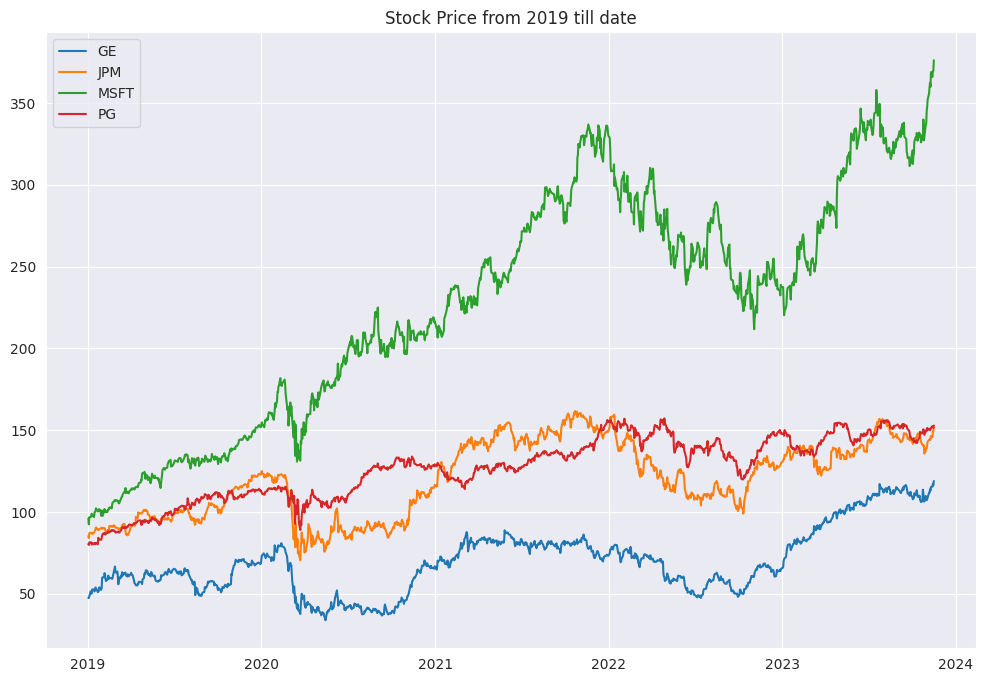

In [8]:
stock_performance(portfolio)

## Stock Returns

### Average returns

1. This gives you the mean performance over a period of time.

2. The average return is the simple mathematical average of a series of returns generated over a specified period of time. An average return is calculated the same way that a simple average is calculated for any set of numbers.

3. So, just by taking the mean of the pct change, we can calculate the average return.

In [9]:
def get_average_return(portfolio):

  #getting the  retuns using pct_change
  returns = portfolio_df.pct_change()

  #mean of the daily returns
  meanDailyReturns=returns.mean()

  # #sample weights
  # weights = np.array([0.25,0.25,0.25,0.25])

  #to get the average return of the portfolio, multiply the mean of daily returns by the weights and take the sum
  portReturn = round(np.sum(meanDailyReturns*weights) *100,2)
  # print(f'Average Return of portfolio calculated daily: {portReturn} %')

  #comparing portfolio performace with overall market performance
  #using ^GSPC to capture the S&P 500 and calculating cumulative returns similarly
  # sp_500 = yf.download('^GSPC',start=start_date,end=end_date)
  # sp_500 = sp_500[['Adj Close']]
  # sp_500['daily_returns'] = sp_500['Adj Close'].pct_change()

  sp_500_meanDailyReturns = round(sp_500['daily_returns'].mean(),4)*100
  # print(f'Average Return of the S&P 500 calulated daily: {sp_500_meanDailyReturns}%')

  avg_return = {'portReturn':portReturn,
                'sp500_return':sp_500_meanDailyReturns}
  avg_return_df = pd.DataFrame(avg_return,index=['Average Daily Return'])
  avg_return_df.plot(kind='bar',rot=0,title='Average Daily Return Comparision %');

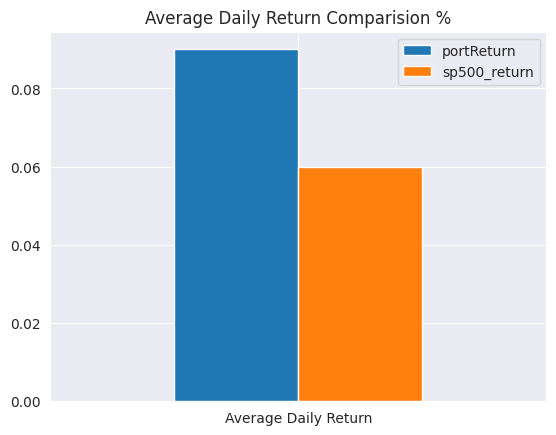

In [10]:
get_average_return(portfolio)

#### Interpretation of Average Return

A 0.08% average return means that, on average, the portfolio has grown by 0.08% for each unit of time, in this case, per day from 2019 till date.
Compared to the average return of the S&P 500 which has grown 0.05% per day over the same time period.

### Cumulative returns

1. Allows you to track portfolio performance over time
2. Just like with interest in your bank account, the cumulative performance gives you the compounded return at each date in your dataset. It tells you; "up until today, this is what the total return has been since the start."
3. Better understood, by plotting a hypothetical growth of $1000 over time.

In [11]:
def get_ind_cumulative_return(portfolio):

  #getting the  retuns using pct_change
  returns = portfolio_df.pct_change()

  #calculate the umulatve returns for each stock in the portfolio
  daily_cum_returns = (returns+1).cumprod()

  #multiply the cumulative return by 1000 get get hypothetical growth
  total_cum_returns = 1000*daily_cum_returns

  #plot the cumulative return
  fig,ax = plt.subplots(figsize=(12,7));
  ax.plot(total_cum_returns,label=portfolio);
  ax.set_title('Hypothetical Growth of $1000');

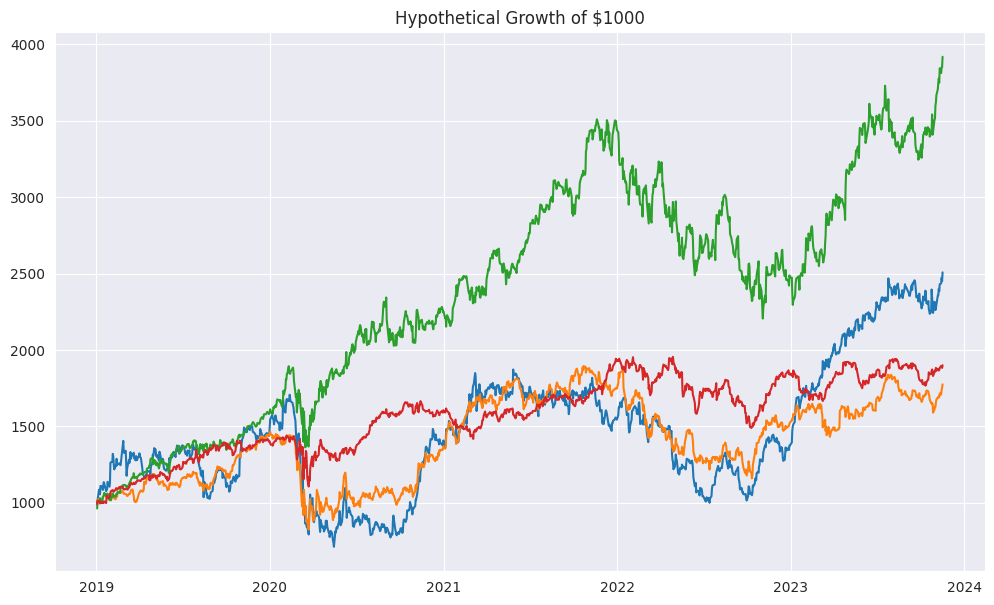

In [12]:
get_ind_cumulative_return(portfolio)

#### Interpreting individual cumulative return

For MSFT, we can see that \\$1000 invested in 2019 would've grown to approx. $3600, netting a cumulative return of approx. 260%!

### Portfolio Cumulative Return

Now that we've seen how the individual stocks have performed over time, similarly, we now have to see how a portfolio of these socks would've performed and compare it to the S&P 500

In [13]:
def get_portfolio_cumulative_return(portfolio):
  #set a smaple allocation to calculate portfolio return. setting 25% of the investment for each stock
  # weights = [0.25,0.25,0.25,0.25]

  #getting the  retuns using pct_change
  returns = portfolio_df.pct_change()

  #calculate daily cumulative return for the portfolio by taking the dot product
  # for eg: first row: (0.099*0.25) + (0.01519*0.25) + (-0.041*0.5) = -0.0493
  #this way you calulate daily cumulative return
  portfolio_returns = returns.dot(weights)

  # from the daily cumulative returns, you calculate total cumulative return
  portfolio_cum_returns = (1+portfolio_returns).cumprod()

  #multiply the cumulative return by 1000 get get hypothetical growth
  portfolio_cum_returns['growth'] = portfolio_cum_returns*1000

  # calculate the cumulative returns of the S&P 500 for comparision
  # sp_500 = yf.download('^GSPC',start=start_date,end=end_date)
  # sp_500 = sp_500[['Adj Close']]
  sp_500['daily_returns'] = sp_500['Adj Close'].pct_change()
  sp_500['cum_returns'] = (1+sp_500['daily_returns']).cumprod()
  sp_500['growth'] =sp_500['cum_returns']*1000

  #plotting returns
  fig,ax = plt.subplots(figsize=(12,7))
  ax.plot(portfolio_cum_returns['growth'],label='portfolio returns')
  ax.plot(sp_500['growth'], label = 'S&P 500')
  ax.set_title('Portfolio Performance vs S&P 500');
  ax.legend();


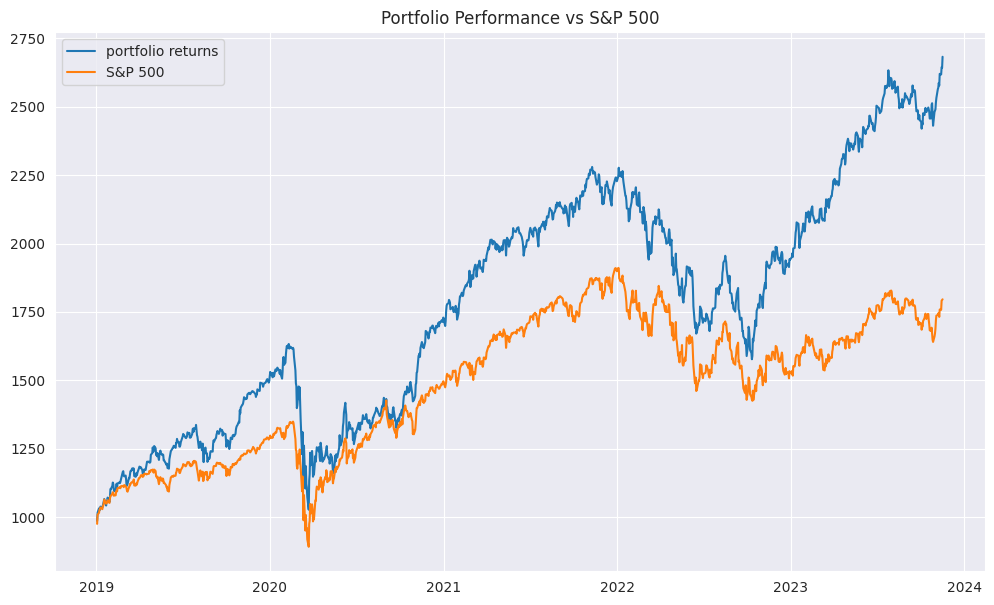

In [14]:
get_portfolio_cumulative_return(portfolio)

#### Interpreting Cumulative Returns

From the graph, we can see that the cumulative return of the portfolio is approx. \$2500.
This means an initial investment of \$1000 would've grown to $2500. In terms of percentage, that equates to 150%.
The S&P 500 in comparison has grown only 75%.

### Dividend History

A Dividend is the distirbution's of the company's profit to it's shareholders. Not every company pays dividends. Companies can also choose to re-invest their profits for future growth than reward shareholders. For an investor, investing in a company that pays dividends is an easy way to earn extra income on top of their initial investment.


In [15]:
#function to get historical dividend data

def get_dividend(ticker):

    #get dividend data
    financials = YahooFinancials(ticker)
    div = financials.get_daily_dividend_data(start_date=start_date,end_date='2022-12-31')

    #check if the company pays dividends
    if div[ticker] == None:
        fig,ax = plt.subplots(figsize=(5,5))
        ax.annotate(f'Sorry, {ticker} does not offer dividends',xy=(0.3,0.5),fontsize=20);
        ax.axis('off')

    else:#if company does pay dividends,then convert to a df and create a plot
        df = pd.DataFrame(div[ticker])
        df.drop('date',axis=1,inplace=True)
        df.rename(columns={'formatted_date':'date'},inplace=True)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date',inplace=True)
        fig,ax=plt.subplots(figsize=(5,5))
        ax.plot(df['amount']);
        ax.set_title(f'Dividend rate: {ticker}');
        plt.xticks(rotation=45)

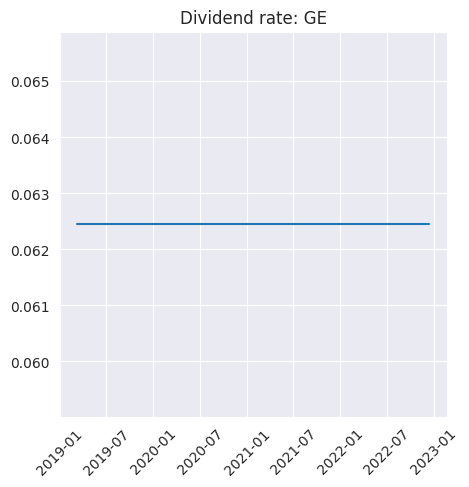

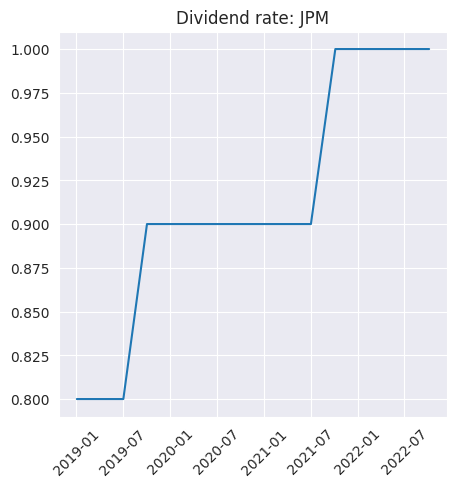

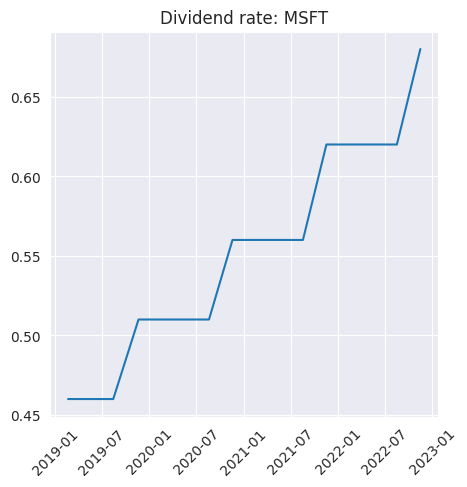

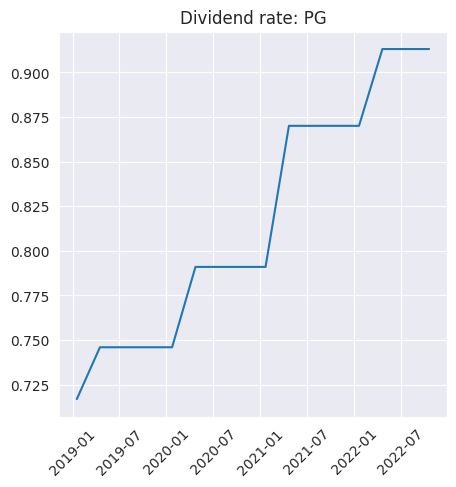

In [16]:
for stock in portfolio:
  get_dividend(stock)

### Difference between arithmetic mean (Average) and geometric mean (Annualized)

*   The arithmetic mean is calculated by adding all the numbers and dividing by the count of that series of numbers.
*   The geometric mean is calculated by taking the product of these numbers and raising it to the inverse series length of the series.
*   For example, if x and y are two numbers, the arithmetic mean is (x+y)/2 and
the geometric mean is (xy)^(1/2).


The geometric mean is used when you're interested in:

*   One investment over many years
*   Multi-period returns, with compounding

The arithmetic mean is used when you're interested in:

*  Many investments over one year
*  Single period forecasts



### Risk

#### Beta value

Beta value of a stock is used to signify risk i.e. if a stock is risky or not. By comparing the stock movement
relative to the overall market such as the S&P 500, the stock can be classified as risky or not. By definition, the market
has a beta value of 1.0. If the beta value of the stock is greater than 1.0, then it is classified as risky and less so if the
value is less than 1.0.

In [17]:
#function to calculate beta value of stock

def calculate_beta(ticker):

    #get data for ticker and SPY whih serves as the market index
    symbols = [ticker,'SPY']
    data = yf.download(symbols, start = start_date,end = end_date)['Adj Close']
    price_change = data.pct_change()
    price_change.drop(price_change.index[0],inplace=True)

    #reshape for linear regression
    X = np.array(price_change[ticker]).reshape((-1,1))
    y = np.array(price_change['SPY'])

    #create splits
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    #predictions
    y_preds = lr.predict(X_test)

    #plot
    fig,ax = plt.subplots(figsize=(5,5));
    ax.plot(X_test,y_preds,linestyle=':',color='orange')
    ax.scatter(y_test,y_preds,alpha=0.5)
    ax.set_title(f' Beta value {lr.coef_}')
    ax.set_xlabel('Market Index:SPY')
    ax.set_ylabel(f'{ticker}')

[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed


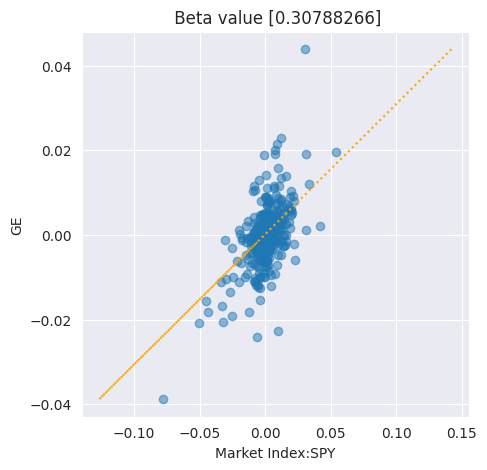

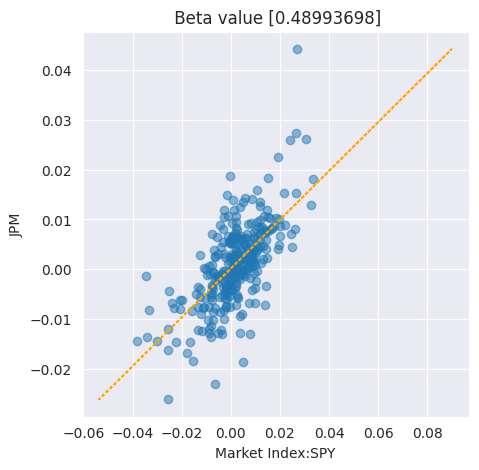

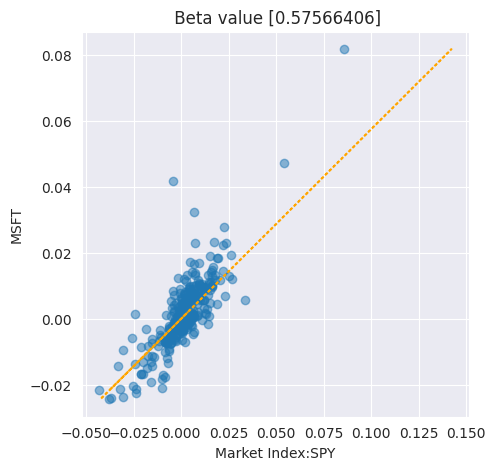

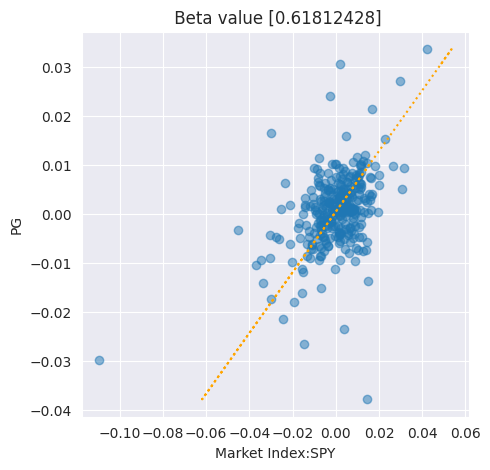

In [18]:
for stock in portfolio:
  calculate_beta(stock)

#### Portfolio Risk

Portfolio risk can be calculated using the covariance matrix.Portfolio variance takes into account individual variance, weights and their correlation.

The risk of a portfolio is not simply the weighted variance of the individual assets. Since the stocks are correlated,
it becomes more complicated. The correlation between assets tell us how they move related to each other.Hence, the risk calculated should also account for the correlation.

The standard deviation of a portfolio is a measure of its risk or volatility. It quantifies how much the returns of the portfolio tend to deviate from the average (mean) return over a specific time period. A higher standard deviation indicates greater volatility, while a lower standard deviation suggests lower volatility.


In [19]:
def covariance(portfolio):
  #covariance matrix
  #get daily_returns
  weights = np.array([0.25,0.25,0.25,0.25])
  daily_returns = portfolio_df.pct_change()

  #annulaize volatility by x'ing it with 250 which is the number of trading days in a year
  cov_matrix = daily_returns.cov() * 250
  cov_df = pd.DataFrame(cov_matrix.values.diagonal()*100,index=portfolio,columns=['covariance %'])

  #correlation
  corr = daily_returns.corr()

  #calculate portfolio variance
  port_variance = np.dot(weights.T, np.dot(cov_matrix, weights)) #formula
  port_variance = round(port_variance*100,1)
  # print(str(port_variance) +"%")

  #calculate portfolio std dev
  #For the variance calculation, we square the weights and the variances.
  #Because of this squaring, the variance is no longer in the same unit of measurement as the original data.
  #Taking the root of the variance means the standard deviation is restored to the original unit of measure and therefore much easier to interpret.
  port_stdev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
  # print(str(round(port_stdev,1)*100) +"%")
  port_stdev = round(port_stdev*100,1)
  # print(str(port_stdev) +"%")

  #plotting results
  fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(20,5))
  plt.subplots_adjust(wspace=0.5)
  cov_df.plot(kind='bar',ax=ax1);
  sns.heatmap(corr,annot=True,cmap='viridis',ax=ax2)
  ax2.set_title('Correlation Matrix')

  ax3.annotate(f'Portfolio Standard Deviation: {port_stdev}%',xy=(0.005,0.5),fontsize=15);
  ax3.axis('off');

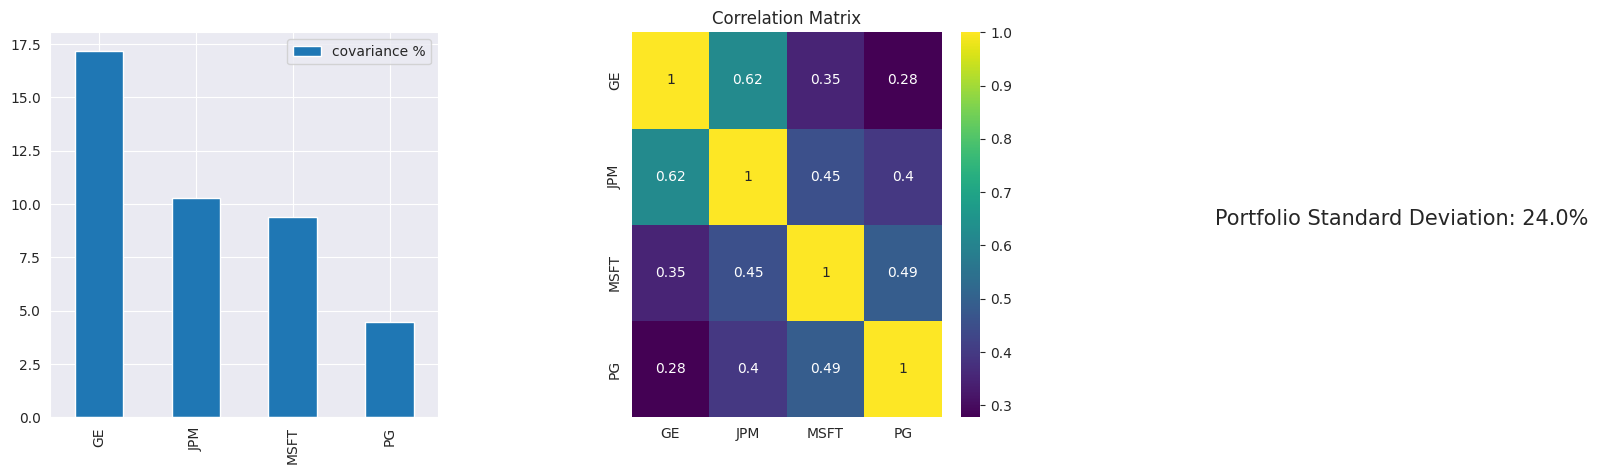

In [20]:
covariance(portfolio)

From, the matrix it is clear to see that GE (17.3%) is the most volatile stock compared to the others.

#### Interpreting risk

The high standard deviation of 23.4% signifies that the portfolio has experienced significant price or return fluctuations. These fluctuations can be both positive and negative, and they can be substantial. Investors with a lower risk tolerance may find such volatility concerning.

On the flip side, despite the high-risk profile, the portfolio has generated an impressive return of 135% over the 5 year period.

Hence, the interpretation of the portfolio's risk depends upon the investor.  Investors with a higher risk tolerance may be more comfortable with the portfolio's volatility if it leads to higher returns, while those with lower risk tolerance may find the risk level less acceptable.

A key factor in this is the investor's time horizon. If the investment horizon is long-term, such as for retirement planning, the portfolio's performance over 5 years, with its associated risk, might be acceptable. However, for short-term goals, the high volatility may pose a greater risk.



In summary, a portfolio standard deviation of 23.4% indicates significant volatility and risk, while the cumulative return of 135% over 5 years indicates strong performance. The interpretation of this data depends on your individual investment goals, risk tolerance, and time horizon. It's essential to carefully consider the risk-return tradeoff and whether the portfolio aligns with your financial objectives and risk comfort level.

#### Viewing returns

Mean and standard deviation are only useful when the distribution is symmetrical. But often in the real world, distributions are often asymmetrical. In such cases, skewness and kurtosis are measures that can help shed more light about the nature of the distribution.

Skewness describes whether the distribution is asymmetrical i.e. if it leans towards the left(positive) or the right(negative).

Suppose plot the daily returns of the portfolio it is left-skewed(positive), it the means the most of the returns are the lesser than the mean which obviously would not be good for us!

Kurtosis deals with the lengths of tails in the distribution or measures of outliers present in the distribution.

If the distribution of the returns has high kurtosis, it means that most of the returns are at the extreme ends thus implying high fluctuations, which again will not be good for us.

Let's plot a histogram of the returns of the S&P 500 and compare them with the returns of the portfolio:

In [21]:
def hist_returns(portfolio):
    #set up plotting
    fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
    plt.subplots_adjust(wspace=0.5)

    #get returns of the portfolio
    returns = portfolio_df.pct_change()
    portfolio_returns = returns.dot(weights)

    #plot the returns
    ax1.hist(sp_500['daily_returns'],bins=50); # S&P 500
    ax2.hist(portfolio_returns,bins=50); # portfolio

    ax1.set_title('Returns of S&P 500');
    ax2.set_title('Returns of Portfolio');

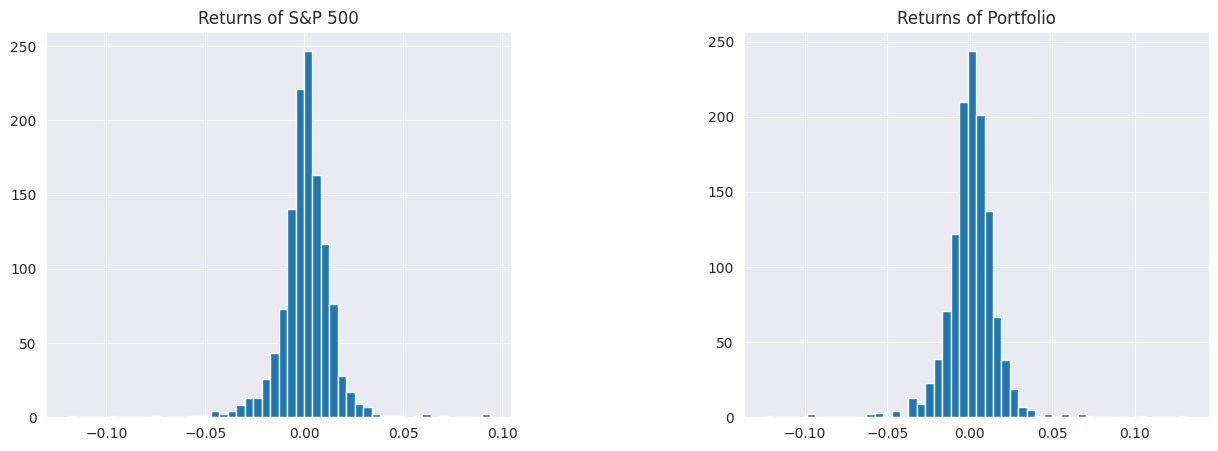

In [22]:
hist_returns(portfolio)

## Modern Portfolio Theory

The modern portfolio theory (MPT) is a practical method for selecting investments in order to maximize their overall returns within an acceptable level of risk. This mathematical framework is used to build a portfolio of investments that maximize the amount of expected return for the collective given level of risk.

American economist Harry Markowitz pioneered this theory in his paper "Portfolio Selection," which was published in the Journal of Finance in 1952.
He was later awarded a Nobel Prize for his work on modern portfolio theory.

A key component of the MPT theory is diversification. Most investments are either high risk and high return or low risk and low return. Markowitz argued that investors could achieve their best results by choosing an optimal mix of the two based on an assessment of their individual tolerance to risk.

Source: [Modern Portfolio Theory](https://urldefense.com/v3/__https://www.investopedia.com/terms/m/modernportfoliotheory.asp__;!!MvWE!A8D_jcz9THgiMXgFsXMRvyYcgjSYKFhsDBtsLLrfeoCrX24cQF5tnVpx8eat9vHSIrZxytGZ2FcSWhMtzNT4h6BJfA$">https://www.investopedia.com/terms/m/modernportfoliotheory.asp)

### PyPortfolioOpt

PyPortfolioOpt is a library that implements portfolio optimization methods, including classical mean-variance optimization techniques and Black-Litterman allocation, as well as more recent developments in the field like shrinkage and Hierarchical Risk Parity.

More information can be found [here](https://urldefense.com/v3/__https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html__;!!MvWE!A8D_jcz9THgiMXgFsXMRvyYcgjSYKFhsDBtsLLrfeoCrX24cQF5tnVpx8eat9vHSIrZxytGZ2FcSWhMtzNSr676PzQ$">https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html) and [here](https://urldefense.com/v3/__https://github.com/robertmartin8/PyPortfolioOpt*an-overview-of-classical-portfolio-optimization-methods__;Iw!!MvWE!A8D_jcz9THgiMXgFsXMRvyYcgjSYKFhsDBtsLLrfeoCrX24cQF5tnVpx8eat9vHSIrZxytGZ2FcSWhMtzNThKKJu4Q$">https://github.com/robertmartin8/PyPortfolioOpt#an-overview-of-classical-portfolio-optimization-methods)

We will be using PyPortfolioOpt to optimize our portfolio.

In [23]:
pip install pyportfolioopt

In [24]:
#import relevant libraries
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

### Efficient Frontier

is a graphical representation of portfolio risk(standard deviation) vs return.

- At every level of return, investors can create a portfolio that offers the lowest possible risk.
- For every level of risk, investors can create a portfolio that offers the highest return.

- Any portfolio that falls outside the Efficient Frontier is considered sub-optimal for one of two reasons: it carries too much risk relative to its return, or too little return relative to its risk.

In [25]:
#efficient frontier needs the expected returns (mu) and the covariance matrix (sigma)

#using mean_historical_return.
#Calculate annualised mean (daily) historical return from input (daily) asset prices
#default is the geometric mean
mu = expected_returns.mean_historical_return(portfolio_df)
mu

#sample_cov
#better option is to use the shrinkage estimator i.e Ledoit Wolf.
#even the docs suggest that. the sample cov sufferes from lack of robustness and misspecifcation
# but for smiplicity sake, we'll use it here.
sigma = risk_models.sample_cov(portfolio_df)
sigma

,GE,JPM,MSFT,PG
GE,0.173310,0.083079,0.044771,0.024525
JPM,0.083079,0.103863,0.044859,0.027089
MSFT,0.044771,0.044859,0.094573,0.031798
PG,0.024525,0.027089,0.031798,0.045080


#### Efficient Frontier for Max Sharpe

The Sharpe Ratio is a measure of risk-adjusted performance for an investment or a portfolio. Simply put, the Sharpe Ratio calculates the excess return per unit of risk. A higher Sharpe Ratio indicates a better risk-adjusted performance. Investors generally prefer investments or portfolios with higher Sharpe Ratios because they provide a better return for the amount of risk taken.


In [26]:
#calculate the efficient frontier
ef1 = EfficientFrontier(mu,sigma)
ef1.max_sharpe()

#this is performance of max_sharpe
perf = ef1.portfolio_performance(risk_free_rate=0.04)

#assemble into a df for readability
ef1_df = pd.DataFrame(perf,index=['Expected annual return %','Annual volatility %','Sharpe Ratio'],columns=['max_sharpe'])
ef1_df = ef1_df.apply(lambda x : round((100*x),2))
ef1_df

#get the optimal weights for each asset
cleaned_weights_1 = dict(ef1.clean_weights())
cleaned_weights_1

{'GE': 0.07091, 'JPM': 0.0, 'MSFT': 0.79928, 'PG': 0.12981}

#### Efficient Frontier for Min Volatility

In [27]:
#min volatility
#optimizes for minimum volatility.returns asset weights for least risk
ef2 = EfficientFrontier(mu,sigma)
ef2.min_volatility()

#this is performance for min_volatility
perf = ef2.portfolio_performance(verbose=True,risk_free_rate=0.04)

#assemble into a df for readability
ef2_df = pd.DataFrame(perf,index=['Expected annual return %','Annual volatility %','Sharpe Ratio'],columns=['min_volatility'])
ef2_df = ef2_df.apply(lambda x : round((100*x),2))
ef2_df

#get the optimal weights for each asset
cleaned_weights_2 = dict(ef2.clean_weights())
cleaned_weights_2

Expected annual return: 16.2%
Annual volatility: 20.1%
Sharpe Ratio: 0.60


{'GE': 0.0477, 'JPM': 0.11659, 'MSFT': 0.106, 'PG': 0.72971}

In [28]:
#put everything together
ef_df = pd.concat([ef1_df,ef2_df],axis=1)
ef_df

,max_sharpe,min_volatility
Expected annual return %,29.15,16.15
Annual volatility %,27.23,20.15
Sharpe Ratio,99.68,60.30


### How to optimally allocate the money based on the weights?

Based on the weights, latest price and amount invested, the next step is to ensure that the amount invested is maximized for each asset's allocated weight.

For eg. if the stock price of GE is \$100 and the total amount invested is \$1000, per the allocation, we have to invest 4.8% in GE which equates to \$48.

We use the DiscreteAllocation class for this. It prioritzies buying shares of the asset that is furthest away from the allocation i.e if the portfolio calls for bying 10 shares of an asset, but with the allocation we have only 10 shares, the other asset allocations are sacrificed to reduce the gap. This way, the left over money is minimized.

#### Max Sharpe

In [29]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

#use latest_prices to get the last row for the latest prices from the df od stock prices
latest_prices = get_latest_prices(portfolio_df)

#use DA to get the allocation and left over money using the optimal weights
da = DiscreteAllocation(cleaned_weights_1, latest_prices, total_portfolio_value=1800)

allocation, leftover = da.greedy_portfolio()
#verbose = True will o/p the allocated weights and desired weigths and also the RMSE between the two

#allocation - dictionary of the ticket and the number of shares to buy
print(allocation, '\n')

#leftover - balance money after investing
print(round(leftover,2))

{'MSFT': 3, 'PG': 2, 'GE': 1} 

246.89


#### Min Volatility

In [30]:
#use latest_prices to get the last row for the latest prices from the df od stock prices
latest_prices = get_latest_prices(portfolio_df)

#use DA to get the allocation and left over money using the optimal weights
da = DiscreteAllocation(cleaned_weights_2, latest_prices, total_portfolio_value=1800)

allocation, leftover = da.greedy_portfolio()
#verbose = True will o/p the allocated weights and desired weigths and also the RMSE between the two

#allocation - dictionary of the ticket and the number of shares to buy
print(allocation, '\n')

#leftover - balance money after investing
print(round(leftover,2))

{'PG': 8, 'JPM': 1, 'MSFT': 1} 

49.74


## Future price prediction - Time Series Modeling

Now that we have some insight on each stock and how to optimally build a portfolio, the next step is to predict future performance of the stocks that we want for our portfolio.

To make predictions, we will build a series of time-series models and select the model with the least RMSE.

We will be using 'AAPL' data for demonstrative purposes

### Stationarity Check

Time series models are usually built on the premise that models are stationary i.e there are patters to the data and by analyzing these patterns, future performance can be predicted with a degree of certainity. However, this rarely happens in real life. There is always some trend or seasonality or a combination of both in the data.Hence the first step is to check for stationarity.

The function below plots rolling-statistics and the ouptut of the Dickey-Fuller test

In [31]:
def plot_trends(ticker):
    df = yf.download(ticker,start=start_date,end=end_date)
    close = df.loc[:,['Adj Close']]

#compute rolling mean and std to see if they are constant
    roll_mean = close.rolling(window=30,center=False).mean()
    roll_std = close.rolling(window=30,center=False).std()

#plot the data
    fig,ax=plt.subplots(figsize=(15,5))
    ax.plot(close,color='blue',label='Original')
    ax.plot(roll_mean,color='red',label='Rolling Mean')
    ax.plot(roll_std,color='green',label='Rolling StdDev')
    ax.legend(loc='best')
    ax.set_title(f'Rolling Statistics of {ticker}');

#dickey Fuller Test
    dftest = adfuller(close['Adj Close'])
    dfoutput = pd.DataFrame(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'],columns=['Values'])

    return dfoutput


[*********************100%%**********************]  1 of 1 completed


,Values
Test Statistic,-1.147104
p-value,0.695927
#Lags Used,0.000000
Number of Observations Used,1228.000000


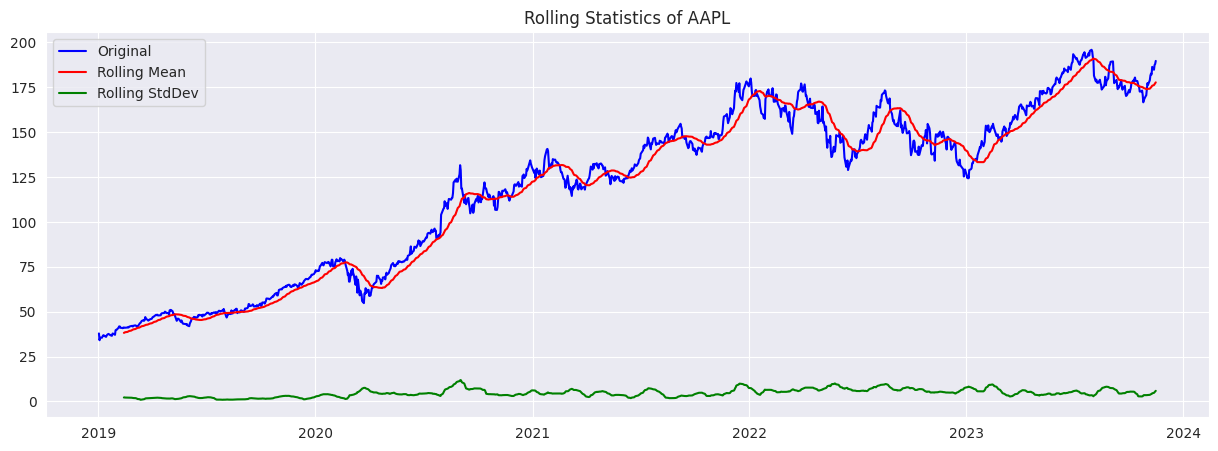

In [32]:
plot_trends('AAPL')

By computing the rolling mean we can see that there is an upward trend in the data signifying non-stationarity. However, since the rolling stddev is fairly straight, we can say that there is not much seasonality in the data. Also shown is the results of the **Dickey-Fuller** test, a statistical method to check for stationarity. The large p-value points means we fail to reject the null-hypothesis which states the data is non-stationary.

### Convert non-stationary to stationary

In [33]:
def differencing(ticker):
    df = yf.download(ticker,start=start_date,end=end_date)
    df_return = df[['Adj Close']]
    df_diff =df_return.diff(periods=1)
    df_diff.dropna(inplace=True)

    #plot the results
    fig,ax = plt.subplots(figsize = (12,5));
    ax.plot(df_diff, label = 'Differenced');

    ax.plot(df_diff.rolling(30).mean(),label = 'Rolling Mean')
    ax.plot(df_diff.rolling(30).std(),label = 'Rolling StdDev')
    ax.set_title(f'Differenced plot of {ticker}')
    ax.legend(loc=2);

    #dickey fuller test
    dftest = adfuller(df_diff['Adj Close'])
    dfoutput = pd.DataFrame(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'],columns=['Values'])

    return dfoutput

[*********************100%%**********************]  1 of 1 completed


,Values
Test Statistic,-36.433006
p-value,0.000000
#Lags Used,0.000000
Number of Observations Used,1227.000000


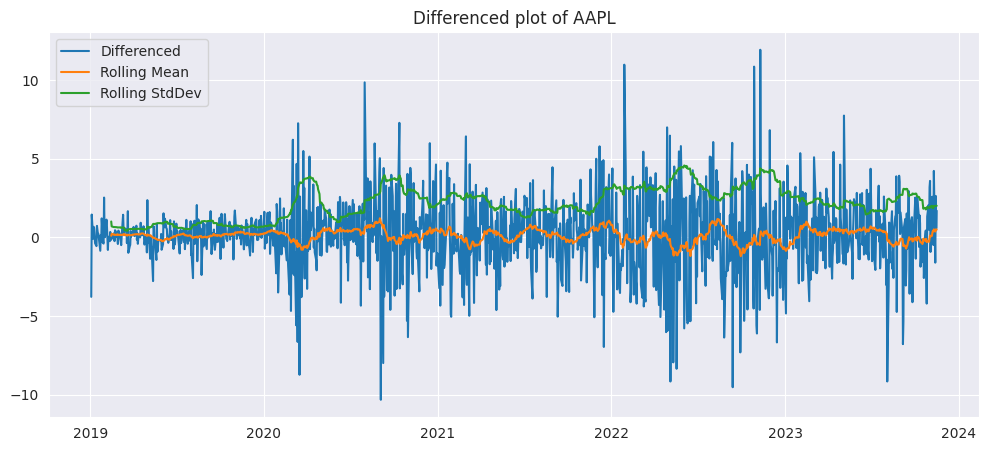

In [34]:
differencing('AAPL')

By simply taking the difference, we can remove non-stationarity from the data set. We can see from the above plot that the mean though not perfectly flat is fairly linear signifying that we have removed the trend.
Since the p-value from the Dickey-Fuller is lesser than the significance value, we can reject the null-hypothesis and thus conclude that the data is now stationary.

### ARIMA model

We will first build and integrated AR and MA model known as ARIMA.

- ARIMA stands for AutoRegressive Integrated Moving Average.
- The AR component refers to the AutoRegressive component and models the relationship between the current value in a time series and its previous values.
- The I stands for integrated and refers to the differencing of the time series data that is used to make stationary.
- The MA component refers to the moving average component. This component models the relationship between the current value in the time series and the past forecast errors. It considers how past prediction errors affect the current observation.


####  ACF and PACF

Since the ARIMA model is a linear regression model, we need to decide on how many regression terms we will use for the model. The Auto-Correlation and Partial Auto Correlation plot(for the AR and MA models respectively) will show the number of lag terms that have the most effect on future price.

[*********************100%%**********************]  1 of 1 completed


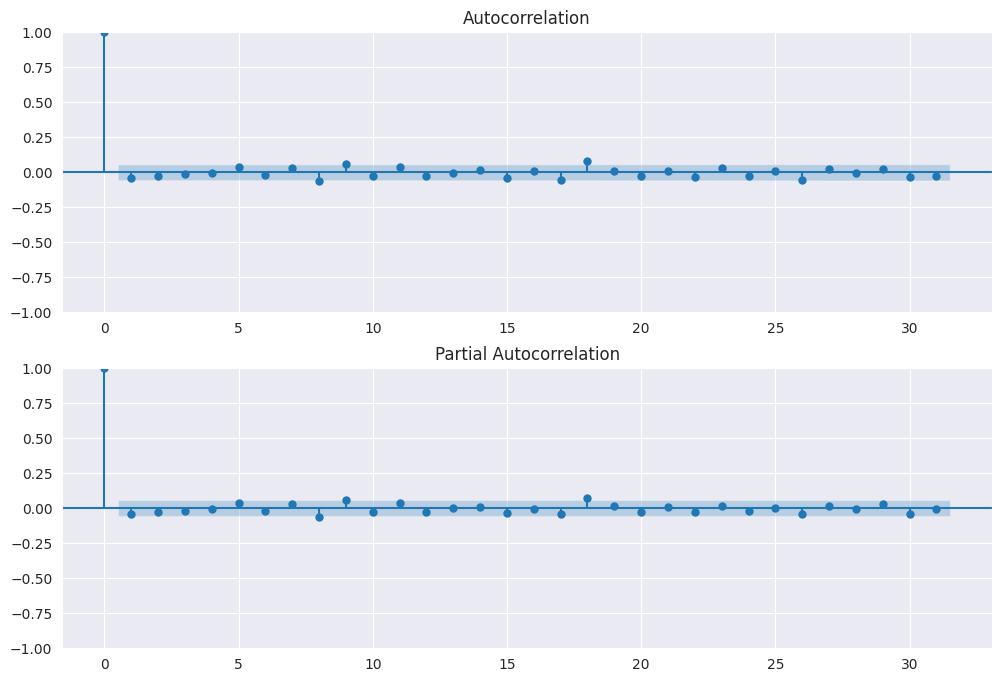

In [35]:
#get stock data
df = yf.download('AAPL',start=start_date,end=end_date)
df_close = df[['Adj Close']]
df_diff =df_close.diff(periods=1)
df_diff.dropna(inplace=True)

#plot ACF and PACF values
fig,(ax1,ax2)=plt.subplots(nrows=2,figsize=(12,8))
acf = plot_acf(df_diff,ax=ax1)
pacf = plot_pacf(df_diff,ax=ax2)

From both the plots, we can see that the 1st lag term i.e the previous day's stock price,for both the AR and MA component, will have the most effect on the next day's price. There are other terms that have an effect as well, but for the sake of simplicity we will use only one term for the model.



Next, we define the train and test sets for modeling. Unlike classification models where can randomly select data for each set, for time series data, we define a percentage of data for the train and test set respectively. Here, we select 75% of the data for train and 25% as test.

In [36]:
#defining train and test sets
cutoff= int(df_close.shape[0]*0.75)
train = df_close[:cutoff]
test = df_close[cutoff:]

AIC score of the ARIMA model is 4134.28
RMSE of the model is $18.4


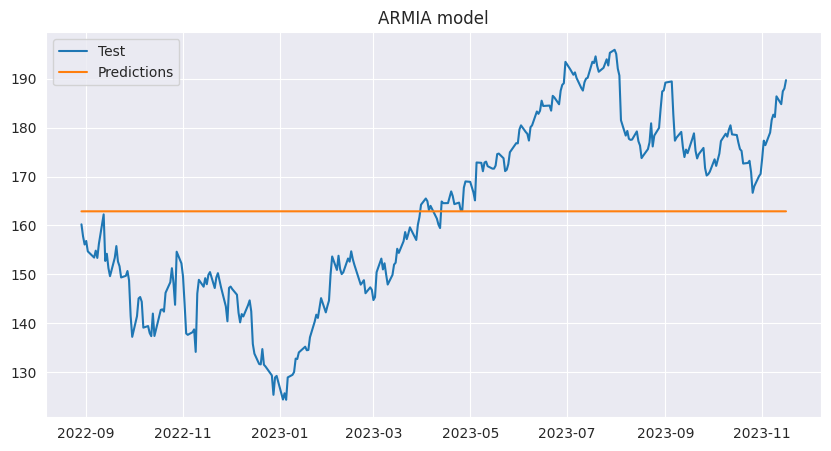

In [37]:
#### setting up the ARIMA model

# Parameters for the model: **(p,d,q)=(1,1,1)** for the model based on the plots:

# 1. p = number of terms for the AR model - from the ACF plot
# 2. d = order of differencing - used to make the data stationary
# 3. q = numer of the terms for the MA model - from the PACF plot

# (1,1,1) ARIMA(p,d,q) based on ACF and PACF plots
#instantiate
model = ARIMA(train,
              order=(1,1,1))

#fit
model_fit = model.fit()
# print(model_fit.summary())

#getting predictions using get_prediction method
arima_predictions = model_fit.get_prediction(start = len(train)+1 , end = len(df_close),dynamic=True)
#predicted_mean gives lists the values
arima_pred_price=arima_predictions.predicted_mean
#converting into a df
arima_pred_price_df = pd.DataFrame(data=arima_pred_price)
#seetting the index to the test dates
arima_pred_price_df.index= test.index

# arima_pred_price_df.head()

#confidence intervals of predictions
arima_conf_int = arima_predictions.conf_int()
arima_conf_int.set_index(test.index,inplace=True)

# arima_conf_int.head()

#plotting predictions with confidence intervals
fig,ax =plt.subplots(figsize=(10,5))
# ax.plot(train,label='Train');
ax.plot(test,label='Test');
ax.plot(arima_pred_price_df,label='Predictions');
# ax.plot(arima_conf_int,label='Confidence Intervals')
# ax.fill_between(arima_conf_int.index,arima_conf_int.iloc[:,0],arima_conf_int.iloc[:,1],color='k',alpha=0.1);
ax.legend(loc=2);
ax.set_title('ARMIA model');

#RMSE and AIC
error_arima = round(np.sqrt(mean_squared_error(test,arima_pred_price_df)),2)
aic_arima = round(model_fit.aic,2)
print(f'AIC score of the ARIMA model is {aic_arima}')
print(f'RMSE of the model is ${error_arima}')


From the plot we can tell that the model does not perform very well when compared to the test values.
From the RMSE score, we can quantify the performance and say the mean prediction of the model is off by \\$20.02, clearly not very good.

### SARIMA model

Next, we will build a SARIMA model. Like the ARIMA models, SARIMA model also depends on past values but has an extra seasonality component to take into account any seasonality patterns

using the the p,d,q values from the ARIMA models as a guide, we can run different combinations to check for the most optimal paramenters. The model that outputs the lowest AIC score , will be used as our model

RMSE of the model is $24.77


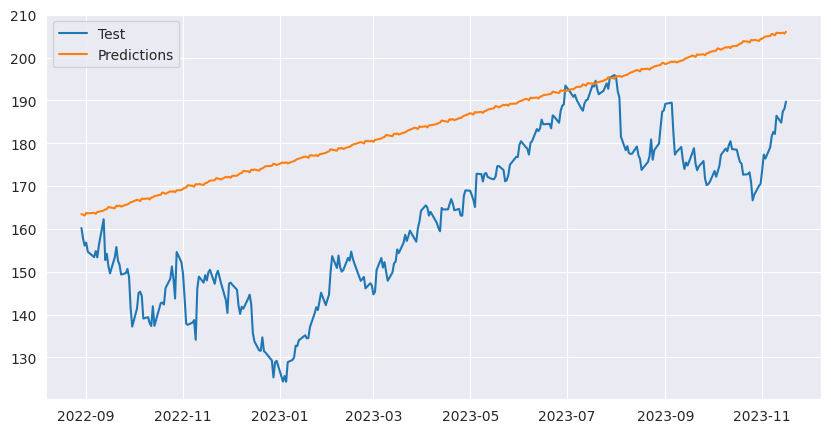

In [38]:
#defining a range for the p,d,q values
p=d=q=range(0,2)
pdq = list(itertools.product(p,d,q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(train,
                          order=comb,
                          seasonal_order=combs,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
#             print('SARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue
#instead of printing, put everything in a df
sari_df = pd.DataFrame(ans,columns=['(p,d,q)','seasonal_combo', 'AIC'])
#get the row with the least AIC
aic_min = sari_df[sari_df['AIC']==sari_df['AIC'].min()]
aic_min

# Plug the optimal parameter values into a new SARIMAX model
sarimax = SARIMAX(train,
                  order=(0,1,1),
                  seasonal_order=(0,1,1,12),
                  enforce_stationarity=False,
                  enforce_invertibility=False)

# Fit the model and print results
output = sarimax.fit()

#get predictions
sarimax_predictions = output.get_prediction(start=len(train)+1,end=len(df_close),dynamic=True)
sarimax_price=sarimax_predictions.predicted_mean
sarimax_predictions_df = pd.DataFrame(data=sarimax_price)
sarimax_predictions_df.index= test.index

#get confidence intervals
sarimax_conf_int = sarimax_predictions.conf_int()
sarimax_conf_int.set_index(test.index,inplace=True)

#plot results
fig,ax =plt.subplots(figsize=(10,5))
# ax.plot(train,label='Train');
ax.plot(test,label='Test');
ax.plot(sarimax_predictions_df,label='Predictions');
# ax.plot(sarimax_conf_int,label='Confidence Intervals')
# ax.fill_between(sarimax_conf_int.index,sarimax_conf_int.iloc[:,0],sarimax_conf_int.iloc[:,1],color='g',alpha=0.1);
ax.legend(loc=2);

#RMSE
error_sarima = round(np.sqrt(mean_squared_error(test,sarimax_predictions_df)),2)
print(f'RMSE of the model is ${error_sarima}')


Compared to the ARIMA model, the SARIMA model performance is much worse.

### Facebook Prophet

The Prophet model is an additive model for time series predicting that was open sourced by Meta in 2017. According to the official documentation, it works best with time series that have strong seasonal effects and several seasons of historical data  Prophet is robust to missing data and shifts in the trend and typically handles outliers well.

Using 'AAPL' to build and test a Prophet model:

[*********************100%%**********************]  1 of 1 completed

DEBUG:cmdstanpy:input tempfile: /tmp/tmprwcn0itd/emilk6cn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprwcn0itd/tflnwr6q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91315', 'data', 'file=/tmp/tmprwcn0itd/emilk6cn.json', 'init=/tmp/tmprwcn0itd/tflnwr6q.json', 'output', 'file=/tmp/tmprwcn0itd/prophet_model7hokhmst/prophet_model-20231117174223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



RMSE of the model is $5.85


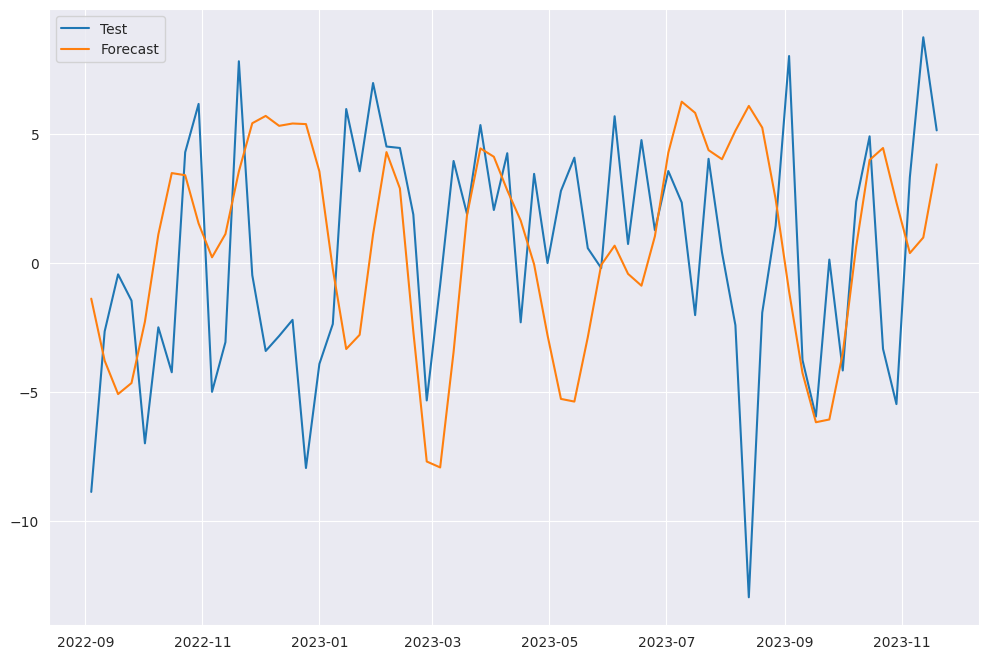

In [50]:
#get stock data
df = yf.download('AAPL',start=start_date,end=end_date)
df_close = df[['Adj Close']]

#resmapling by weekly
df_weekly = df_close.resample('W').mean()

df_weekly = df_weekly.diff(periods=1)
df_weekly.dropna(inplace=True)

#setting up df to be able to run Prophet
#reset index
df_weekly.reset_index(inplace=True)
#rename columns per prophet conventions
df_weekly.rename(columns={'Adj Close': 'y',
                         'Date':'ds'},inplace=True)

#defining train and test sets
cutoff= int(df_weekly.shape[0]*0.75)
train = df_weekly[:cutoff]
test = df_weekly[cutoff:]

#instantiate
m = Prophet(seasonality_mode='multiplicative',
            weekly_seasonality=True,
            daily_seasonality = True,
            yearly_seasonality = True,
            interval_width=0.90,
           )

#fit
m.fit(train)

#forecasts - creating future dates using in built make_future_dataframe method
future = m.make_future_dataframe(periods=len(test),freq='W',include_history=False)

#predicting yhat
forecast = m.predict(future)

#creating a df of predicted values
forecast_values = forecast[['ds', 'yhat']]

#set the index for the plots
forecast_values.set_index('ds',inplace=True)
test.set_index('ds',inplace=True)

#plotting results
fig,ax=plt.subplots(figsize=(12,8))
# ax.plot(train,label='Train')
ax.plot(test,label='Test')
# ax.plot(df_weekly,label='Current Price')
ax.plot(forecast_values['yhat'],label='Forecast')
# ax.fill_between(test.index,forecast_values['yhat_lower'],forecast_values['yhat_upper'],color='g',alpha=0.1);
ax.legend();

#RMSE
error_fb = round(np.sqrt(mean_squared_error(test,forecast_values['yhat'])),2)
print(f'RMSE of the model is ${error_fb}')

#### Regularization

We can try to optimize the model by running a loop for the seasonality and changepoint values.
These are deciding how much to penalize seasonality and changepoints changes in the data i.e. if the values are small
for the seasonality changes, then the effect of seasonal changes in the data is dampened and vice versa.

In [51]:
#run a loop for different regularization values
seasonality_scale = [0.1, 0.2, 0.3, 0.4, 0.5]
changepoint_scale = [0.1, 0.2, 0.3, 0.4, 0.5]
errors = []
new_error_fb = None

for season in seasonality_scale:
    for changepoint in changepoint_scale:
        #instantiate
        m = Prophet(seasonality_mode='multiplicative',
                weekly_seasonality=True,
                daily_seasonality = True,
                yearly_seasonality = True,
                interval_width=0.90,
                seasonality_prior_scale=season,
                changepoint_prior_scale=changepoint
               )

        #fit
        m.fit(train)

        #forecasts - creating future dates using in built make_future_dataframe method
        future = m.make_future_dataframe(periods=len(test),freq='W',include_history=False)

        #predicting yhat
        forecast = m.predict(future)

        #getting only yhat values
        forecast_values = forecast[['ds', 'yhat']]

        #setting the index
        forecast_values.set_index('ds',inplace=True)

        #rmse values
        rmse = round(np.sqrt(mean_squared_error(test,forecast_values['yhat'])),3)
        errors.append(rmse)
        new_error_fb = min(errors)
#         print(f'seasonality_scale:{season}, changepoint_scale:{changepoint}, rmse:{rmse}')

print('----------------------------------------------')
print(f'Smallest RMSE after looping is {new_error_fb}')
print(f'Original RMSE is {error_fb}')

DEBUG:cmdstanpy:input tempfile: /tmp/tmprwcn0itd/etfqx8f7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprwcn0itd/v6p79iss.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45986', 'data', 'file=/tmp/tmprwcn0itd/etfqx8f7.json', 'init=/tmp/tmprwcn0itd/v6p79iss.json', 'output', 'file=/tmp/tmprwcn0itd/prophet_modeloiv1t1oa/prophet_model-20231117174246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmprwcn0itd/beqkmuf5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprwcn0itd/n36s2qas.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

----------------------------------------------
Smallest RMSE after looping is 5.124
Original RMSE is 5.85


Now that we have a model, we can make predictions of the next year:

[*********************100%%**********************]  1 of 1 completed

DEBUG:cmdstanpy:input tempfile: /tmp/tmprwcn0itd/8d5kktwo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprwcn0itd/att3fkfl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37374', 'data', 'file=/tmp/tmprwcn0itd/8d5kktwo.json', 'init=/tmp/tmprwcn0itd/att3fkfl.json', 'output', 'file=/tmp/tmprwcn0itd/prophet_modeltg53_bra/prophet_model-20231117173515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


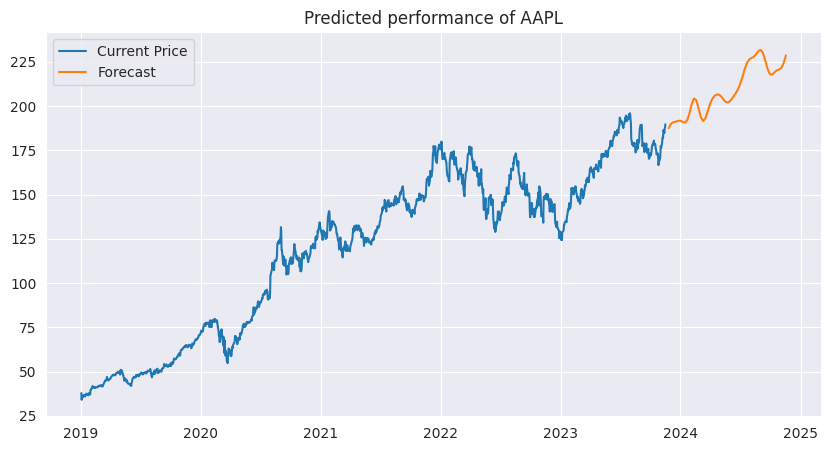

In [41]:
### Using Prophet to get forecast of 'AAPL' for the next year



#get stock data
df = yf.download('AAPL',start=start_date,end=end_date)
df_close = df[['Adj Close']]

# resmapling by weekly
df_weekly = df_close.resample('W').mean()

df_weekly_diff = df_weekly.diff(periods=1)
df_weekly_diff.dropna(inplace=True)

# setting up df to be able to run Prophet
#reset index
df_weekly_diff.reset_index(inplace=True)

#rename columns per prophet conventions
df_weekly_diff.rename(columns={'Adj Close': 'y',
                         'Date':'ds'},inplace=True)


#instantiate
m = Prophet(seasonality_mode='multiplicative',
            weekly_seasonality=True,
            daily_seasonality = True,
            yearly_seasonality = True,
            interval_width=0.90,
            seasonality_prior_scale = 0.4,
            changepoint_prior_scale = 0.3
           )

#fit
m.fit(df_weekly_diff)

#forecasts - creating future dates using in built make_future_dataframe method
future = m.make_future_dataframe(periods=52,freq='W',include_history=False)

#predicting yhat
forecast = m.predict(future)

#creating a df of predicted values
forecast_values = forecast[['ds', 'yhat']]

#set the index for the plots
forecast_values.set_index('ds',inplace=True)
df_weekly_diff.set_index('ds',inplace=True)


#taking the inverse difference of the predicted values to get the original values
# the inverse diff is the cumsum of the first value of the org series & the first differences series
forecast_values.rename(columns={'yhat':'y'},inplace=True)
invdiff = np.r_[df_weekly['Adj Close'].iloc[-1],forecast_values['y'][1:]].cumsum()
invdiff_df = pd.DataFrame(data=invdiff,index = forecast_values.index,columns=['y'])

#plotting results
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(df_close,label='Current Price')
ax.plot(invdiff_df['y'],label='Forecast')
ax.set_title('Predicted performance of AAPL')
ax.legend();

### Comparing model performance

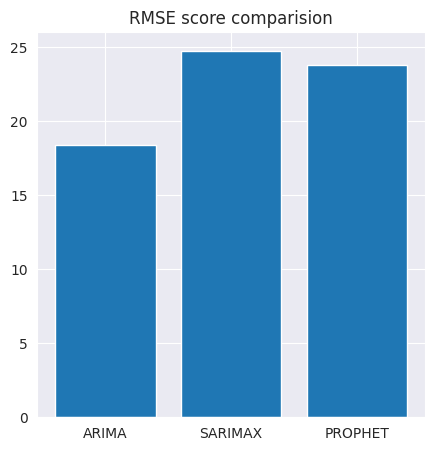

In [42]:
### Model performance comparisions

fig,ax =plt.subplots(figsize=(5,5))
ax.bar(x=['ARIMA', 'SARIMAX','PROPHET'],height=[error_arima,error_sarima,new_error_fb]);
ax.set_title('RMSE score comparision');

From the plot, we can see the prophet model clearly outshines the rest. Hence, we will use that for making predictions for our chose stock.

## Building Portfolio

### Predictions of chosen stock


Following function is used to plot past and forecast prices for stocks in the portfolio:

In [43]:
def plot_forecast_price(portfolio):

    price_df = pd.DataFrame()
    for stock in portfolio_df:
        #get stock data
        stock_price = pd.DataFrame(portfolio_df[stock])
#         df = yf.download(ticker,start=start_date,end=end_date)
#         df_close = df[['Adj Close']]

        #resmapling by weekly
        df_weekly = stock_price.resample('W').mean()
        df_weekly_diff = stock_price.diff(periods=1)
        df_weekly_diff.dropna(inplace=True)

        #setting up df to be able to run Prophet
        #reset index
        df_weekly_diff.reset_index(inplace=True)
        #  rename columns per prophet conventions
        df_weekly_diff.rename(columns={stock : 'y',
                                 'Date':'ds'},inplace=True)


        #instantiate
        m = Prophet(seasonality_mode='multiplicative',
                    weekly_seasonality=True,
                    daily_seasonality = True,
                    yearly_seasonality = True,
                    interval_width=0.90,
                    seasonality_prior_scale = 0.4,
                    changepoint_prior_scale = 0.3
                   )

        #fit
        m.fit(df_weekly_diff)

        #forecasts - creating future dates using in built make_future_dataframe method
        future = m.make_future_dataframe(periods=52,freq='W',include_history=False)

        #predicting yhat
        forecast = m.predict(future)

        #creating a df of predicted values
        forecast_values = forecast[['ds', 'yhat']]

        #set the index for the plots
        forecast_values.set_index('ds',inplace=True)
        df_weekly_diff.set_index('ds',inplace=True)

        #taking the inverse difference of the predicted values to get the original values
        # the inverse diff is the cumsum of the first value of the org series & the first differences series
        forecast_values.rename(columns={'yhat':'y'},inplace=True)
        invdiff = np.r_[df_weekly[stock].iloc[-1],forecast_values['y'][1:]].cumsum()
        invdiff_df = pd.DataFrame(data=invdiff,index = forecast_values.index,columns=['y'])

        price_df = pd.concat([price_df,invdiff_df],axis=1)

        #plotting results
        fig,ax=plt.subplots(figsize=(10,5))
        ax.plot(df_weekly,label='Current Price')
        ax.plot(invdiff_df['y'],label='Forecast')
        ax.set_title(f'Predicted values of {stock}')
        ax.legend();

    price_df.columns = portfolio

    return price_df

DEBUG:cmdstanpy:input tempfile: /tmp/tmprwcn0itd/wdb3hoqq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprwcn0itd/yz6n5674.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92024', 'data', 'file=/tmp/tmprwcn0itd/wdb3hoqq.json', 'init=/tmp/tmprwcn0itd/yz6n5674.json', 'output', 'file=/tmp/tmprwcn0itd/prophet_model8ay5c640/prophet_model-20231117173516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmprwcn0itd/bdh5qt05.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprwcn0itd/d0tw27xz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

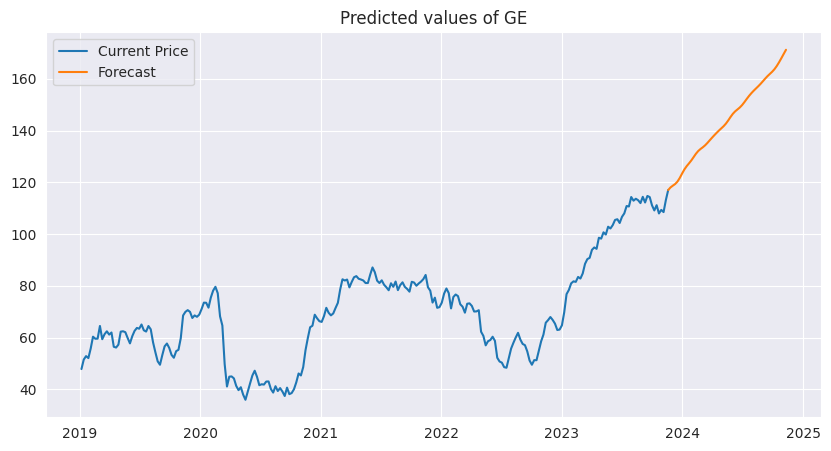

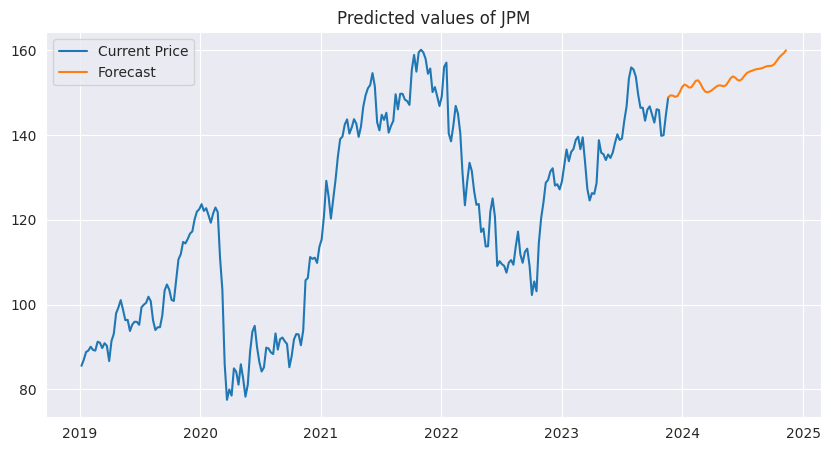

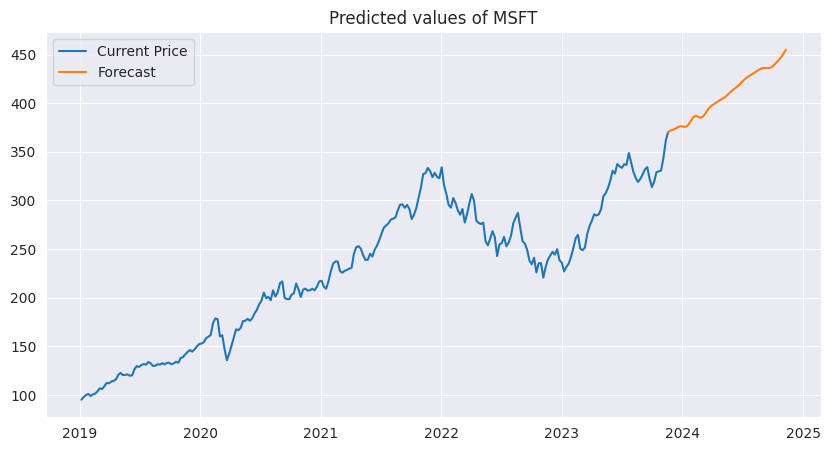

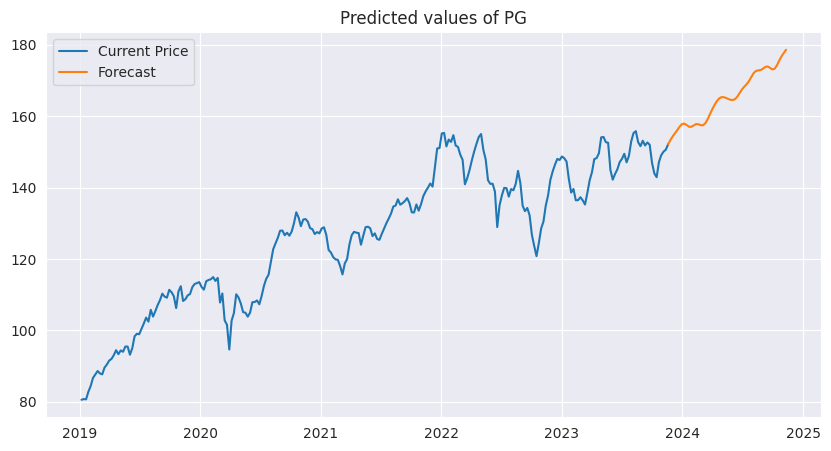

In [44]:
forecast_portfolio = plot_forecast_price(portfolio)

### Predictions of portfolio

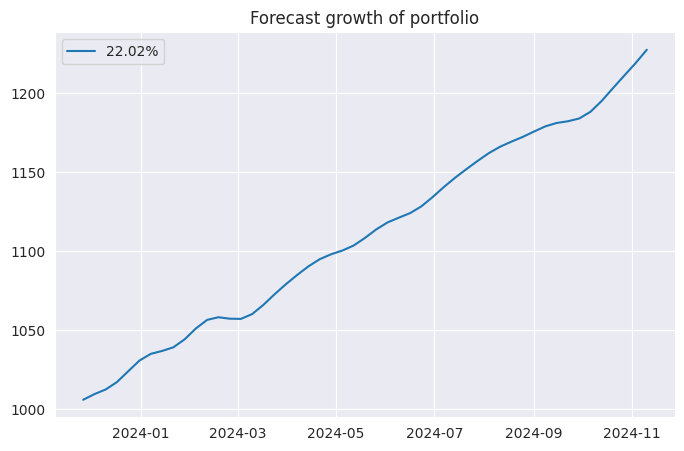

In [45]:
# #current returns
# #getting the  retuns using pct_change
# returns = portfolio_df.pct_change()

# #calculate daily cumulative return for the portfolio by taking the dot product
# # for eg: first row: (0.099*0.25) + (0.01519*0.25) + (-0.041*0.5) = -0.0493
# #this way you calulate daily cumulative return
# portfolio_returns = returns.dot(weights)

# # from the daily cumulative returns, you calculate total cumulative return
# portfolio_cum_returns = (1+portfolio_returns).cumprod()

# #multiply the cumulative return by 1000 get get hypothetical growth
# portfolio_cum_returns['growth'] = portfolio_cum_returns*1000

#forecast returns
#getting the  retuns using pct_change
forecast_returns = forecast_portfolio.pct_change()

#calculate daily cumulative return for the portfolio by taking the dot product
# for eg: first row: (0.099*0.25) + (0.01519*0.25) + (-0.041*0.5) = -0.0493
#this way you calulate daily cumulative return
forecast_returns = forecast_returns.dot(weights)

# from the daily cumulative returns, you calculate total cumulative return
forecast_cum_returns = (1+forecast_returns).cumprod()

#multiply the cumulative return by 1000 get get hypothetical growth
forecast_cum_returns['growth'] = forecast_cum_returns*1000

#percent growth
percent_growth = ((forecast_cum_returns['growth'][-1] - forecast_cum_returns['growth'][1])/forecast_cum_returns['growth'][1]) *100
percent_growth = round(percent_growth,2)

#plot it
fig,ax = plt.subplots(figsize=(8,5))
# ax.plot(portfolio_cum_returns['growth'],label='current')
ax.plot(forecast_cum_returns['growth'],label = str(percent_growth)+'%');
ax.set_title('Forecast growth of portfolio')
ax.legend();

In [46]:
((forecast_cum_returns['growth'][-1] - forecast_cum_returns['growth'][1])/forecast_cum_returns['growth'][1]) *100

22.016929761841492

## Conclusions

### Limitations

1. All the models are purely mathematical models and cannot take into account black swan events.
2. More sophisticated models using Deep Learning can be built to get more accurate forecasts.
3. Dividend data is not incorporated while calculating overall returns.
4. Currently, the invested amount is distributed equally amongst all the stocks.
   The amounts can be tuned based on the investor's appetite for risk.

### Recommendations

1. By plugging in amounts and companies in the model, the investor can play around and maximize his/her returns.

2. Looking at the stock market in general, there was a drastic spike around 2020.
   There has not been a decline to pre-2020 levels and hence, it might be prudent to collect past data only
   from 2020 onwards rather than from all the way back to 2017.